In [144]:
import numpy as np
import torch
from torch import nn
import tqdm

import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

106
12
40
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


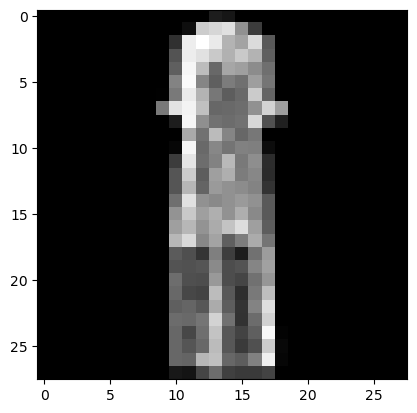

Label: 3
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


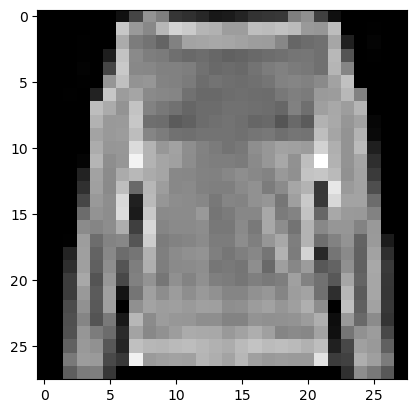

Label: 2
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


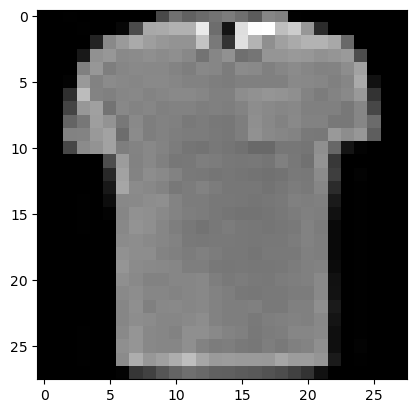

Label: 0
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


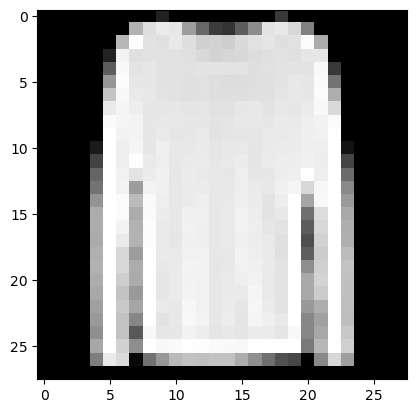

Label: 2
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


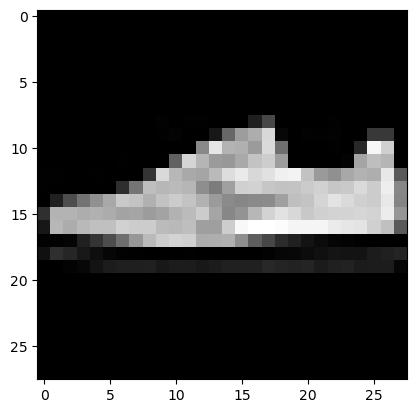

Label: 7
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


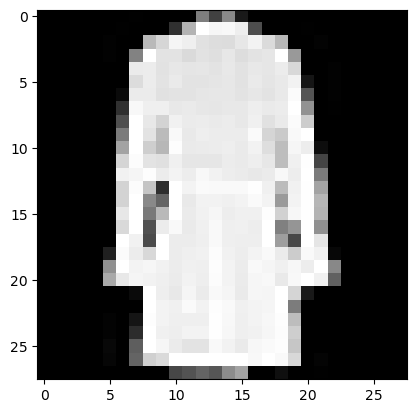

Label: 3
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


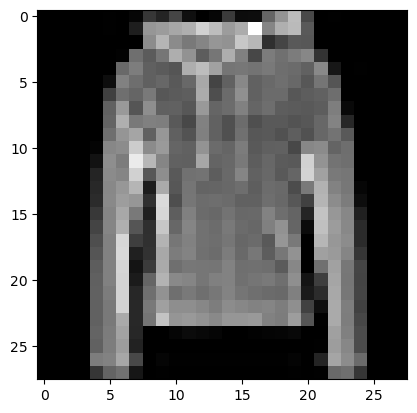

Label: 2
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


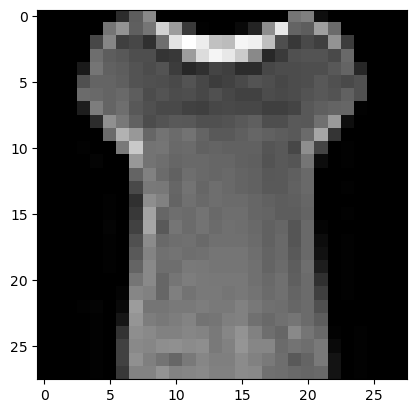

Label: 0
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


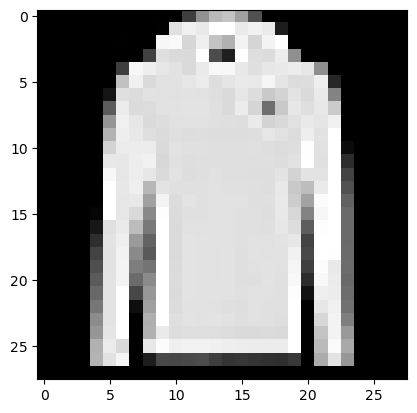

Label: 2
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


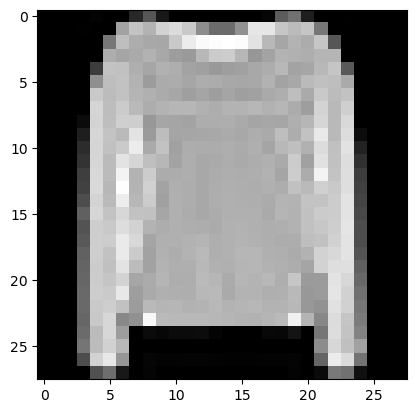

Label: 2
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


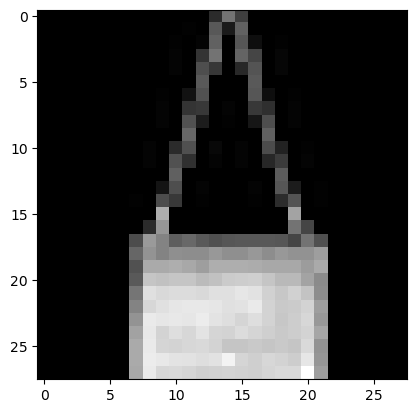

Label: 8
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


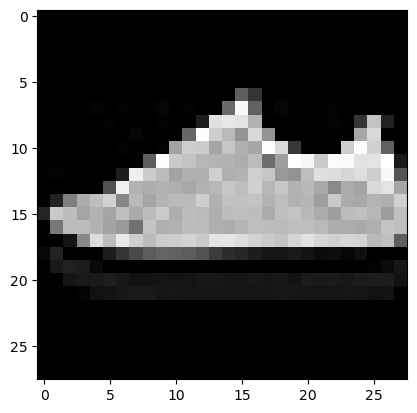

Label: 7
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


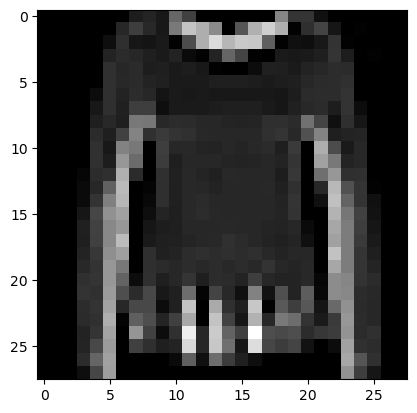

Label: 2
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


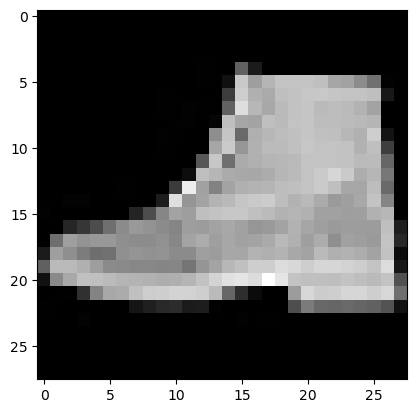

Label: 9
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


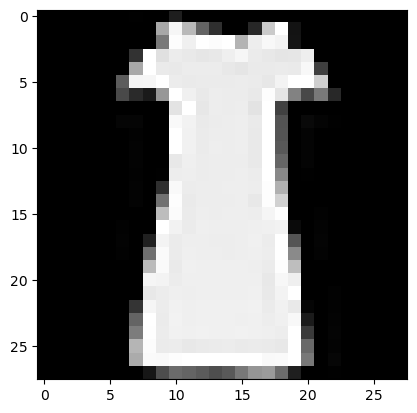

Label: 3
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


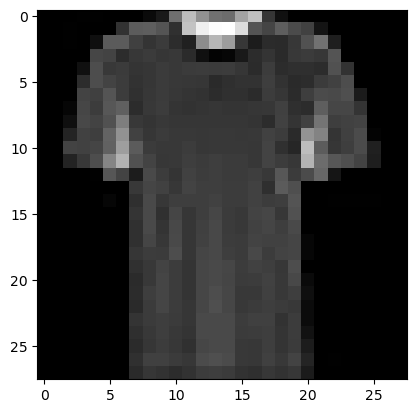

Label: 0


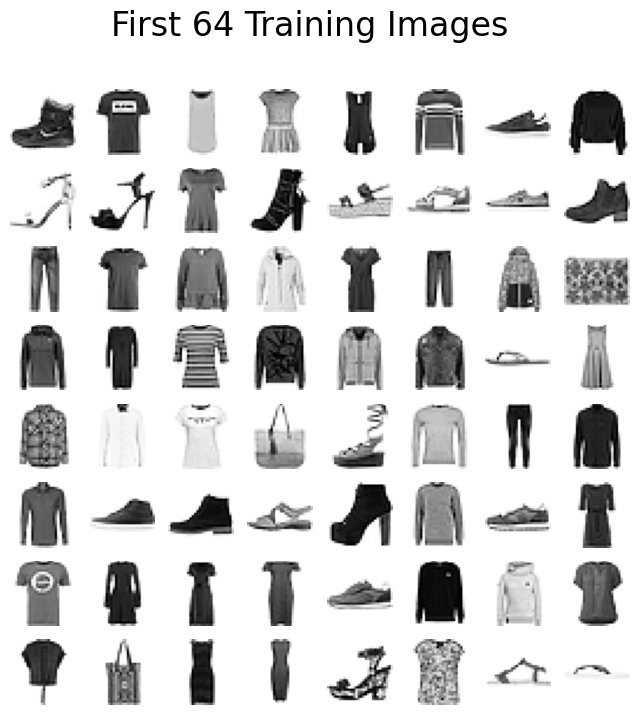

In [145]:
train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


# Use the following code to create a validation set of 10%, from the training set
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)


# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size = train_batch_size, shuffle = True)
val_batches = DataLoader(val_split, batch_size = train_batch_size, shuffle = True)
test_batches = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True)
                                           
num_train_batches = len(train_batches)
num_val_batches = len(val_batches)
num_test_batches = len(test_batches)


print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


#Sample code to visulaize the first sample in first 16 batches 

batch_num = 0
for train_features, train_labels in train_batches:
    
    if batch_num == 16:
        break    # break here
    
    batch_num = batch_num +1
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")

# Sample code to plot N^2 images from the dataset
def plot_images(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )



**Construct FCN 100K model**

In [528]:
class ACAIGFCNDropout(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_rate=0.5):
        super(ACAIGFCNDropout, self).__init__()

        # Define the network layers and activation functions
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        # Add dropout layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(p=dropout_rate) for _ in range(len(hidden_dims))])

    def forward(self, input):
        # Define how your model propagates the input through the network

        output = torch.nn.functional.relu(self.input_layer(input))
        
        for hidden_layer, dropout_layer in zip(self.hidden_layers, self.dropout_layers):
            output = torch.nn.functional.relu(hidden_layer(output))
            output = dropout_layer(output)  # Apply dropout after activation

        output = self.output_layer(output)

        return output
    

In [529]:
import torch.nn.init as init

epochs = 25

def init_weights_kaiming(m):
    if type(m) == nn.Linear:
        init.kaiming_uniform_(m.weight)

# hidden_dims = np.array([112, 106]) # For 100K constraint
hidden_dims = np.array([59, 49]) # For 50K constraint
# hidden_dims = np.array([205, 189]) # For 200K constraint


model_K = ACAIGFCNDropout(input_dim = 784, output_dim = 10, hidden_dims = hidden_dims, dropout_rate=0.5)
model_K.apply(init_weights_kaiming)

train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model_K.parameters(), lr= 0.0008)

for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model_K.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
        output = model_K(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation

    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model_K.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model_K(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  4%|█▊                                          | 1/25 [00:02<01:01,  2.54s/it]

Epoch: 0; Validation Accuracy:82.0652186870575%


  8%|███▌                                        | 2/25 [00:04<00:56,  2.47s/it]

Epoch: 1; Validation Accuracy:79.61956262588501%


 12%|█████▎                                      | 3/25 [00:07<00:53,  2.44s/it]

Epoch: 2; Validation Accuracy:86.1413061618805%


 16%|███████                                     | 4/25 [00:09<00:51,  2.43s/it]

Epoch: 3; Validation Accuracy:82.6086938381195%


 20%|████████▊                                   | 5/25 [00:12<00:48,  2.42s/it]

Epoch: 4; Validation Accuracy:85.326087474823%


 24%|██████████▌                                 | 6/25 [00:14<00:45,  2.42s/it]

Epoch: 5; Validation Accuracy:86.6847813129425%


 28%|████████████▎                               | 7/25 [00:17<00:43,  2.43s/it]

Epoch: 6; Validation Accuracy:90.4891312122345%


 32%|██████████████                              | 8/25 [00:19<00:41,  2.43s/it]

Epoch: 7; Validation Accuracy:86.4130437374115%


 36%|███████████████▊                            | 9/25 [00:21<00:38,  2.43s/it]

Epoch: 8; Validation Accuracy:86.95651888847351%


 40%|█████████████████▏                         | 10/25 [00:24<00:36,  2.45s/it]

Epoch: 9; Validation Accuracy:90.21739363670349%


 44%|██████████████████▉                        | 11/25 [00:26<00:34,  2.44s/it]

Epoch: 10; Validation Accuracy:88.04348111152649%


 48%|████████████████████▋                      | 12/25 [00:29<00:31,  2.44s/it]

Epoch: 11; Validation Accuracy:83.96739363670349%


 52%|██████████████████████▎                    | 13/25 [00:31<00:29,  2.43s/it]

Epoch: 12; Validation Accuracy:86.95651888847351%


 56%|████████████████████████                   | 14/25 [00:34<00:26,  2.44s/it]

Epoch: 13; Validation Accuracy:87.771737575531%


 60%|█████████████████████████▊                 | 15/25 [00:36<00:24,  2.43s/it]

Epoch: 14; Validation Accuracy:86.95651888847351%


 64%|███████████████████████████▌               | 16/25 [00:38<00:21,  2.42s/it]

Epoch: 15; Validation Accuracy:88.04348111152649%


 68%|█████████████████████████████▏             | 17/25 [00:41<00:19,  2.42s/it]

Epoch: 16; Validation Accuracy:88.3152186870575%


 72%|██████████████████████████████▉            | 18/25 [00:43<00:16,  2.42s/it]

Epoch: 17; Validation Accuracy:89.13043737411499%


 76%|████████████████████████████████▋          | 19/25 [00:46<00:14,  2.41s/it]

Epoch: 18; Validation Accuracy:87.5%


 80%|██████████████████████████████████▍        | 20/25 [00:48<00:12,  2.42s/it]

Epoch: 19; Validation Accuracy:89.673912525177%


 84%|████████████████████████████████████       | 21/25 [00:51<00:09,  2.43s/it]

Epoch: 20; Validation Accuracy:88.8586938381195%


 88%|█████████████████████████████████████▊     | 22/25 [00:53<00:07,  2.45s/it]

Epoch: 21; Validation Accuracy:88.5869562625885%


 92%|███████████████████████████████████████▌   | 23/25 [00:56<00:04,  2.47s/it]

Epoch: 22; Validation Accuracy:90.21739363670349%


 96%|█████████████████████████████████████████▎ | 24/25 [00:58<00:02,  2.46s/it]

Epoch: 23; Validation Accuracy:85.597825050354%


100%|███████████████████████████████████████████| 25/25 [01:00<00:00,  2.44s/it]

Epoch: 24; Validation Accuracy:89.94565010070801%


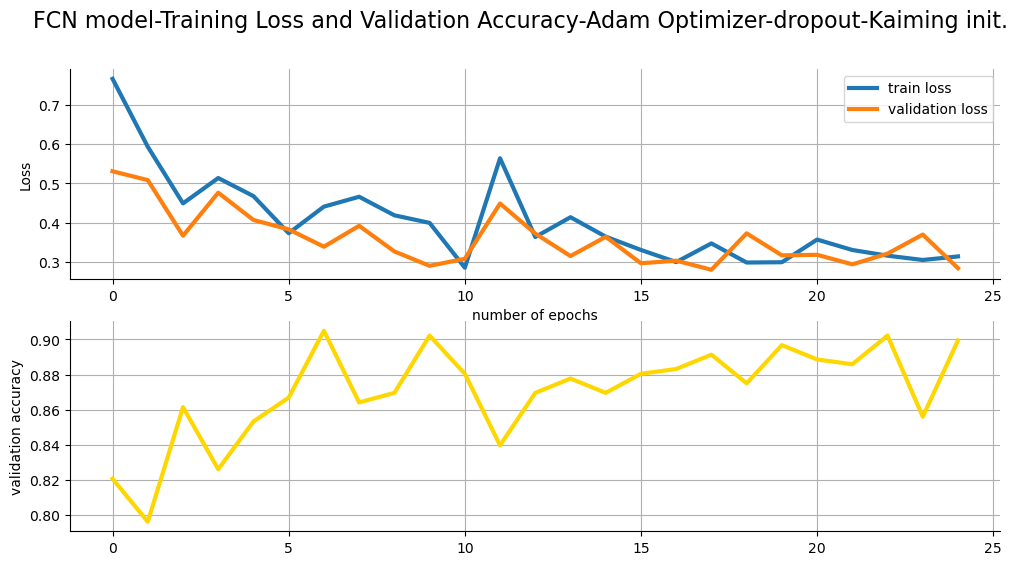

In [530]:
import seaborn as sns

plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("FCN model-Training Loss and Validation Accuracy-Adam Optimizer-dropout-Kaiming init.", fontsize=16)

sns.despine()

In [535]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model_K.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model_K(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 87.96% ± 2.09%


In [538]:
hidden_dims = np.array([784, 205, 189,10])

num_of_weights = 0

for i in range (len(hidden_dims)-2):
    num_of_weights = num_of_weights + (hidden_dims[i]+1) * hidden_dims[i+1]
    
print(num_of_weights)
    

199859


**Construct CNN 100K model**

In [322]:
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        print("In model", train_features.shape)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=40, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.cnn2 = nn.Conv2d(in_channels=40, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.cnn1(x)))
        x = self.dropout1(x)
        x = self.maxpool2(F.relu(self.cnn2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc(x)
        return x


In [323]:
model_CNN = CNNModel()
model_CNN.apply(init_weights_kaiming)

In model torch.Size([240, 784])


CNNModel(
  (cnn1): Conv2d(1, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (cnn2): Conv2d(40, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [324]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_weights = count_parameters(model_CNN)
print(num_weights)

96474


In [325]:
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model_CNN.parameters(), lr= 0.0008)

for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
#         print(train_features.shape)
        train_features = train_features.view(-1, 1, 28, 28)
        
        # Set model into training mode
        model_CNN.train()
        
        # Reshape images into a vector
#         train_features = train_features.reshape(-1, 28*28)
#         print("After reshape",train_features.shape)
        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
#         train_features = train_features.reshape(-1, 1, 28, 28)
#         print("reshape back", train_features.shape)
        output = model_CNN(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation

    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            val_features = val_features.view(-1, 1, 28, 28)
            
            model_CNN.eval()
            
             # Reshape validation images into a vector
#             val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model_CNN(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  4%|█▊                                          | 1/25 [00:46<18:31, 46.33s/it]

Epoch: 0; Validation Accuracy:86.95651888847351%


  8%|███▌                                        | 2/25 [01:33<17:53, 46.66s/it]

Epoch: 1; Validation Accuracy:84.78260636329651%


 12%|█████▎                                      | 3/25 [02:19<17:01, 46.44s/it]

Epoch: 2; Validation Accuracy:88.04348111152649%


 16%|███████                                     | 4/25 [03:06<16:22, 46.80s/it]

Epoch: 3; Validation Accuracy:91.03260636329651%


 20%|████████▊                                   | 5/25 [03:53<15:38, 46.93s/it]

Epoch: 4; Validation Accuracy:87.771737575531%


 24%|██████████▌                                 | 6/25 [04:40<14:51, 46.92s/it]

Epoch: 5; Validation Accuracy:90.7608687877655%


 28%|████████████▎                               | 7/25 [05:27<14:04, 46.92s/it]

Epoch: 6; Validation Accuracy:90.21739363670349%


 32%|██████████████                              | 8/25 [06:13<13:12, 46.63s/it]

Epoch: 7; Validation Accuracy:90.21739363670349%


 36%|███████████████▊                            | 9/25 [06:59<12:22, 46.39s/it]

Epoch: 8; Validation Accuracy:89.13043737411499%


 40%|█████████████████▏                         | 10/25 [07:45<11:35, 46.38s/it]

Epoch: 9; Validation Accuracy:91.576087474823%


 44%|██████████████████▉                        | 11/25 [08:32<10:51, 46.50s/it]

Epoch: 10; Validation Accuracy:89.402174949646%


 48%|████████████████████▋                      | 12/25 [09:18<10:01, 46.28s/it]

Epoch: 11; Validation Accuracy:93.75%


 52%|██████████████████████▎                    | 13/25 [10:04<09:13, 46.12s/it]

Epoch: 12; Validation Accuracy:93.20651888847351%


 56%|████████████████████████                   | 14/25 [10:50<08:26, 46.07s/it]

Epoch: 13; Validation Accuracy:90.4891312122345%


 60%|█████████████████████████▊                 | 15/25 [11:37<07:43, 46.38s/it]

Epoch: 14; Validation Accuracy:90.7608687877655%


 64%|███████████████████████████▌               | 16/25 [12:23<06:56, 46.23s/it]

Epoch: 15; Validation Accuracy:89.402174949646%


 68%|█████████████████████████████▏             | 17/25 [13:09<06:09, 46.17s/it]

Epoch: 16; Validation Accuracy:92.3913061618805%


 72%|██████████████████████████████▉            | 18/25 [13:55<05:22, 46.09s/it]

Epoch: 17; Validation Accuracy:93.478262424469%


 76%|████████████████████████████████▋          | 19/25 [14:40<04:36, 46.01s/it]

Epoch: 18; Validation Accuracy:91.576087474823%


 80%|██████████████████████████████████▍        | 20/25 [15:26<03:49, 45.97s/it]

Epoch: 19; Validation Accuracy:91.576087474823%


 84%|████████████████████████████████████       | 21/25 [16:12<03:03, 45.98s/it]

Epoch: 20; Validation Accuracy:93.478262424469%


 88%|█████████████████████████████████████▊     | 22/25 [16:58<02:18, 46.02s/it]

Epoch: 21; Validation Accuracy:92.3913061618805%


 92%|███████████████████████████████████████▌   | 23/25 [17:44<01:31, 45.97s/it]

Epoch: 22; Validation Accuracy:90.4891312122345%


 96%|█████████████████████████████████████████▎ | 24/25 [18:30<00:45, 45.94s/it]

Epoch: 23; Validation Accuracy:92.11956262588501%


100%|███████████████████████████████████████████| 25/25 [19:16<00:00, 46.26s/it]

Epoch: 24; Validation Accuracy:90.4891312122345%


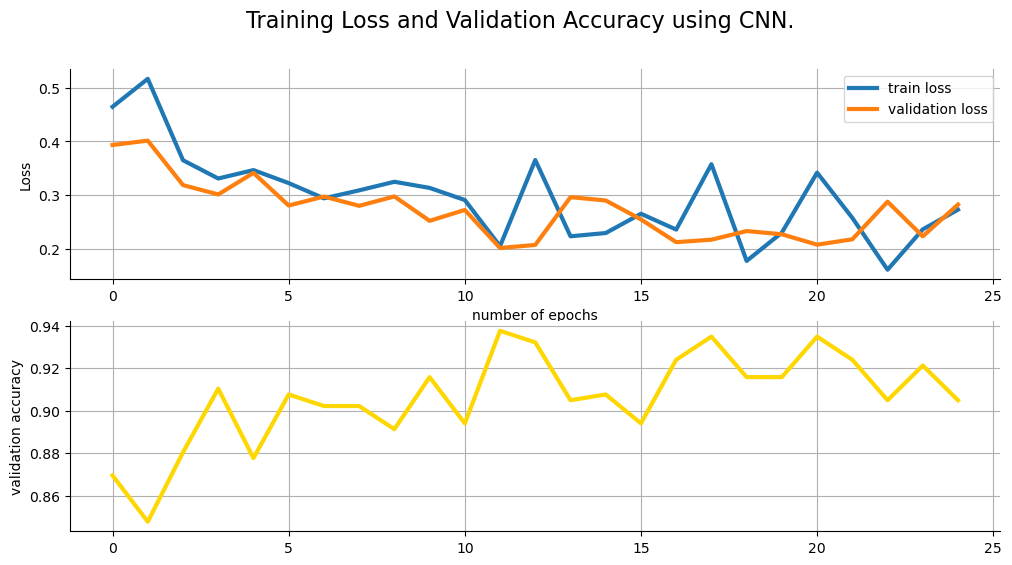

In [339]:
import seaborn as sns

plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using CNN.", fontsize=16)

sns.despine()

In [346]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model_CNN.eval()
        # Reshape test images into a vector
#         test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model_CNN(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 91.36% ± 1.75%


**Construct CNN 50K**

In [475]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        print("In model", train_features.shape)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=23, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.cnn2 = nn.Conv2d(in_channels=23, out_channels=46, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.fc = nn.Linear(46 * 7 * 7, 10)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.cnn1(x)))
        x = self.dropout1(x)
        x = self.maxpool2(F.relu(self.cnn2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 46 * 7 * 7)
        x = self.fc(x)
        return x

In [476]:
model_CNN = CNNModel()
model_CNN.apply(init_weights_kaiming)

In model torch.Size([240, 1, 28, 28])


CNNModel(
  (cnn1): Conv2d(1, 23, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (cnn2): Conv2d(23, 46, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc): Linear(in_features=2254, out_features=10, bias=True)
)

In [477]:
num_weights = count_parameters(model_CNN)
print(num_weights)

49644


In [447]:
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model_CNN.parameters(), lr= 0.0008)

for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
#         print(train_features.shape)
        train_features = train_features.view(-1, 1, 28, 28)
        
        # Set model into training mode
        model_CNN.train()
        
        # Reshape images into a vector
#         train_features = train_features.reshape(-1, 28*28)
#         print("After reshape",train_features.shape)
        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
#         train_features = train_features.reshape(-1, 1, 28, 28)
#         print("reshape back", train_features.shape)
        output = model_CNN(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation

    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            val_features = val_features.view(-1, 1, 28, 28)
            
            model_CNN.eval()
            
             # Reshape validation images into a vector
#             val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model_CNN(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  4%|█▊                                          | 1/25 [00:28<11:28, 28.69s/it]

Epoch: 0; Validation Accuracy:82.88043737411499%


  8%|███▌                                        | 2/25 [00:57<10:57, 28.57s/it]

Epoch: 1; Validation Accuracy:88.5869562625885%


 12%|█████▎                                      | 3/25 [01:25<10:30, 28.68s/it]

Epoch: 2; Validation Accuracy:85.05434989929199%


 16%|███████                                     | 4/25 [01:56<10:16, 29.35s/it]

Epoch: 3; Validation Accuracy:90.21739363670349%


 20%|████████▊                                   | 5/25 [02:26<09:51, 29.56s/it]

Epoch: 4; Validation Accuracy:88.8586938381195%


 24%|██████████▌                                 | 6/25 [02:57<09:31, 30.05s/it]

Epoch: 5; Validation Accuracy:86.4130437374115%


 28%|████████████▎                               | 7/25 [03:27<09:03, 30.18s/it]

Epoch: 6; Validation Accuracy:90.7608687877655%


 32%|██████████████                              | 8/25 [03:58<08:36, 30.39s/it]

Epoch: 7; Validation Accuracy:89.13043737411499%


 36%|███████████████▊                            | 9/25 [04:29<08:07, 30.49s/it]

Epoch: 8; Validation Accuracy:88.8586938381195%


 40%|█████████████████▏                         | 10/25 [04:59<07:34, 30.29s/it]

Epoch: 9; Validation Accuracy:90.7608687877655%


 44%|██████████████████▉                        | 11/25 [05:29<07:06, 30.45s/it]

Epoch: 10; Validation Accuracy:88.04348111152649%


 48%|████████████████████▋                      | 12/25 [06:01<06:40, 30.80s/it]

Epoch: 11; Validation Accuracy:88.5869562625885%


 52%|██████████████████████▎                    | 13/25 [06:31<06:06, 30.50s/it]

Epoch: 12; Validation Accuracy:88.5869562625885%


 56%|████████████████████████                   | 14/25 [07:00<05:30, 30.00s/it]

Epoch: 13; Validation Accuracy:90.21739363670349%


 60%|█████████████████████████▊                 | 15/25 [07:30<04:59, 29.95s/it]

Epoch: 14; Validation Accuracy:91.576087474823%


 64%|███████████████████████████▌               | 16/25 [07:59<04:28, 29.79s/it]

Epoch: 15; Validation Accuracy:92.9347813129425%


 68%|█████████████████████████████▏             | 17/25 [08:28<03:56, 29.51s/it]

Epoch: 16; Validation Accuracy:91.576087474823%


 72%|██████████████████████████████▉            | 18/25 [08:57<03:25, 29.31s/it]

Epoch: 17; Validation Accuracy:91.847825050354%


 76%|████████████████████████████████▋          | 19/25 [09:26<02:55, 29.23s/it]

Epoch: 18; Validation Accuracy:90.21739363670349%


 80%|██████████████████████████████████▍        | 20/25 [09:55<02:25, 29.13s/it]

Epoch: 19; Validation Accuracy:91.576087474823%


 84%|████████████████████████████████████       | 21/25 [10:23<01:56, 29.02s/it]

Epoch: 20; Validation Accuracy:92.9347813129425%


 88%|█████████████████████████████████████▊     | 22/25 [10:52<01:26, 28.99s/it]

Epoch: 21; Validation Accuracy:91.576087474823%


 92%|███████████████████████████████████████▌   | 23/25 [11:21<00:57, 28.94s/it]

Epoch: 22; Validation Accuracy:90.21739363670349%


 96%|█████████████████████████████████████████▎ | 24/25 [11:50<00:28, 28.88s/it]

Epoch: 23; Validation Accuracy:91.03260636329651%


100%|███████████████████████████████████████████| 25/25 [12:19<00:00, 29.57s/it]

Epoch: 24; Validation Accuracy:92.11956262588501%


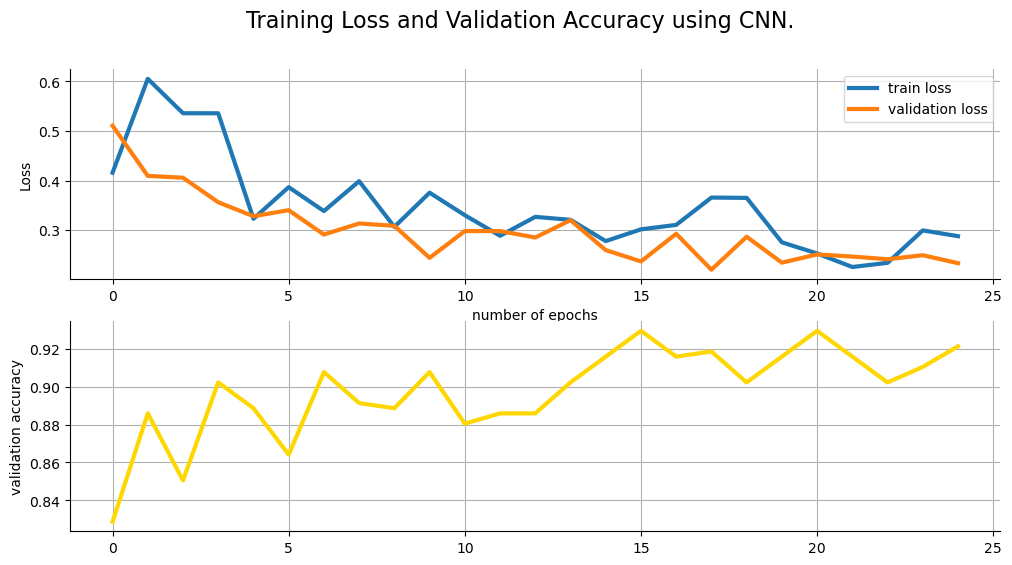

In [448]:
import seaborn as sns

plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using CNN.", fontsize=16)

sns.despine()

In [449]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model_CNN.eval()
        # Reshape test images into a vector
#         test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model_CNN(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 91.04% ± 1.49%


**Construct CNN 20K**

In [478]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        print("In model", train_features.shape)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.cnn2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.fc = nn.Linear(24 * 7 * 7, 10)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.cnn1(x)))
        x = self.dropout1(x)
        x = self.maxpool2(F.relu(self.cnn2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 24 * 7 * 7)
        x = self.fc(x)
        return x

In [479]:
model_CNN = CNNModel()
model_CNN.apply(init_weights_kaiming)

In model torch.Size([240, 1, 28, 28])


CNNModel(
  (cnn1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (cnn2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc): Linear(in_features=1176, out_features=10, bias=True)
)

In [480]:
num_weights = count_parameters(model_CNN)
print(num_weights)

19306


In [467]:
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model_CNN.parameters(), lr= 0.0008)

for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
#         print(train_features.shape)
        train_features = train_features.view(-1, 1, 28, 28)
        
        # Set model into training mode
        model_CNN.train()
        
        # Reshape images into a vector
#         train_features = train_features.reshape(-1, 28*28)
#         print("After reshape",train_features.shape)
        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
#         train_features = train_features.reshape(-1, 1, 28, 28)
#         print("reshape back", train_features.shape)
        output = model_CNN(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation

    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            val_features = val_features.view(-1, 1, 28, 28)
            
            model_CNN.eval()
            
             # Reshape validation images into a vector
#             val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model_CNN(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  4%|█▊                                          | 1/25 [00:17<06:53, 17.24s/it]

Epoch: 0; Validation Accuracy:80.70651888847351%


  8%|███▌                                        | 2/25 [00:34<06:34, 17.16s/it]

Epoch: 1; Validation Accuracy:84.78260636329651%


 12%|█████▎                                      | 3/25 [00:51<06:18, 17.21s/it]

Epoch: 2; Validation Accuracy:86.1413061618805%


 16%|███████                                     | 4/25 [01:08<06:02, 17.28s/it]

Epoch: 3; Validation Accuracy:85.05434989929199%


 20%|████████▊                                   | 5/25 [01:26<05:46, 17.30s/it]

Epoch: 4; Validation Accuracy:85.597825050354%


 24%|██████████▌                                 | 6/25 [01:43<05:28, 17.26s/it]

Epoch: 5; Validation Accuracy:89.673912525177%


 28%|████████████▎                               | 7/25 [02:00<05:10, 17.24s/it]

Epoch: 6; Validation Accuracy:84.5108687877655%


 32%|██████████████                              | 8/25 [02:18<04:53, 17.26s/it]

Epoch: 7; Validation Accuracy:89.94565010070801%


 36%|███████████████▊                            | 9/25 [02:35<04:36, 17.26s/it]

Epoch: 8; Validation Accuracy:89.13043737411499%


 40%|█████████████████▏                         | 10/25 [02:53<04:22, 17.50s/it]

Epoch: 9; Validation Accuracy:86.4130437374115%


 44%|██████████████████▉                        | 11/25 [03:10<04:03, 17.40s/it]

Epoch: 10; Validation Accuracy:91.30434989929199%


 48%|████████████████████▋                      | 12/25 [03:27<03:45, 17.35s/it]

Epoch: 11; Validation Accuracy:89.13043737411499%


 52%|██████████████████████▎                    | 13/25 [03:44<03:27, 17.30s/it]

Epoch: 12; Validation Accuracy:89.13043737411499%


 56%|████████████████████████                   | 14/25 [04:02<03:10, 17.28s/it]

Epoch: 13; Validation Accuracy:88.04348111152649%


 60%|█████████████████████████▊                 | 15/25 [04:19<02:52, 17.27s/it]

Epoch: 14; Validation Accuracy:88.04348111152649%


 64%|███████████████████████████▌               | 16/25 [04:36<02:35, 17.30s/it]

Epoch: 15; Validation Accuracy:88.5869562625885%


 68%|█████████████████████████████▏             | 17/25 [04:53<02:18, 17.27s/it]

Epoch: 16; Validation Accuracy:88.04348111152649%


 72%|██████████████████████████████▉            | 18/25 [05:11<02:00, 17.23s/it]

Epoch: 17; Validation Accuracy:89.94565010070801%


 76%|████████████████████████████████▋          | 19/25 [05:28<01:43, 17.25s/it]

Epoch: 18; Validation Accuracy:89.402174949646%


 80%|██████████████████████████████████▍        | 20/25 [05:45<01:26, 17.26s/it]

Epoch: 19; Validation Accuracy:86.95651888847351%


 84%|████████████████████████████████████       | 21/25 [06:02<01:09, 17.28s/it]

Epoch: 20; Validation Accuracy:88.8586938381195%


 88%|█████████████████████████████████████▊     | 22/25 [06:20<00:51, 17.27s/it]

Epoch: 21; Validation Accuracy:89.402174949646%


 92%|███████████████████████████████████████▌   | 23/25 [06:37<00:34, 17.38s/it]

Epoch: 22; Validation Accuracy:89.94565010070801%


 96%|█████████████████████████████████████████▎ | 24/25 [06:55<00:17, 17.41s/it]

Epoch: 23; Validation Accuracy:90.4891312122345%


100%|███████████████████████████████████████████| 25/25 [07:12<00:00, 17.31s/it]

Epoch: 24; Validation Accuracy:88.8586938381195%


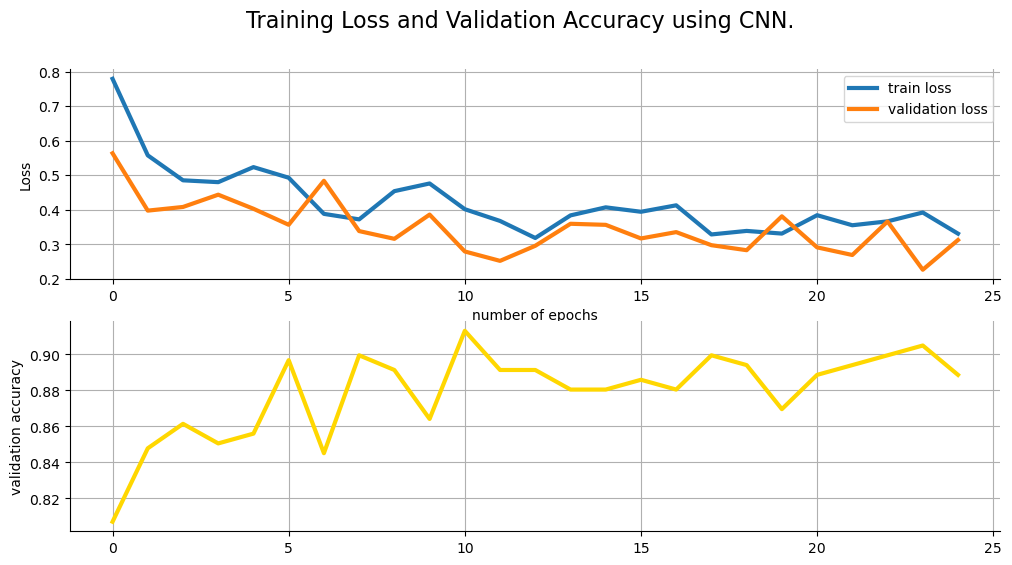

In [468]:
import seaborn as sns

plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using CNN.", fontsize=16)

sns.despine()

In [473]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model_CNN.eval()
        # Reshape test images into a vector
#         test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model_CNN(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 89.38% ± 1.76%


**Construct CNN 10K**

In [490]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        print("In model", train_features.shape)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=7, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.cnn2 = nn.Conv2d(in_channels=7, out_channels=14, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.fc = nn.Linear(14 * 7 * 7, 10)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.cnn1(x)))
        x = self.dropout1(x)
        x = self.maxpool2(F.relu(self.cnn2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 14 * 7 * 7)
        x = self.fc(x)
        return x

In [491]:
model_CNN = CNNModel()
model_CNN.apply(init_weights_kaiming)

In model torch.Size([240, 1, 28, 28])


CNNModel(
  (cnn1): Conv2d(1, 7, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (cnn2): Conv2d(7, 14, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc): Linear(in_features=686, out_features=10, bias=True)
)

In [492]:
num_weights = count_parameters(model_CNN)
print(num_weights)

9516


In [493]:
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model_CNN.parameters(), lr= 0.0008)

for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
#         print(train_features.shape)
        train_features = train_features.view(-1, 1, 28, 28)
        
        # Set model into training mode
        model_CNN.train()
        
        # Reshape images into a vector
#         train_features = train_features.reshape(-1, 28*28)
#         print("After reshape",train_features.shape)
        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
#         train_features = train_features.reshape(-1, 1, 28, 28)
#         print("reshape back", train_features.shape)
        output = model_CNN(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation

    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            val_features = val_features.view(-1, 1, 28, 28)
            
            model_CNN.eval()
            
             # Reshape validation images into a vector
#             val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model_CNN(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  4%|█▊                                          | 1/25 [00:12<05:06, 12.77s/it]

Epoch: 0; Validation Accuracy:79.61956262588501%


  8%|███▌                                        | 2/25 [00:25<04:51, 12.67s/it]

Epoch: 1; Validation Accuracy:80.1630437374115%


 12%|█████▎                                      | 3/25 [00:38<04:38, 12.67s/it]

Epoch: 2; Validation Accuracy:81.25%


 16%|███████                                     | 4/25 [00:50<04:25, 12.63s/it]

Epoch: 3; Validation Accuracy:82.0652186870575%


 20%|████████▊                                   | 5/25 [01:03<04:13, 12.65s/it]

Epoch: 4; Validation Accuracy:81.79348111152649%


 24%|██████████▌                                 | 6/25 [01:15<04:00, 12.66s/it]

Epoch: 5; Validation Accuracy:86.95651888847351%


 28%|████████████▎                               | 7/25 [01:28<03:49, 12.74s/it]

Epoch: 6; Validation Accuracy:86.6847813129425%


 32%|██████████████                              | 8/25 [01:41<03:37, 12.78s/it]

Epoch: 7; Validation Accuracy:88.04348111152649%


 36%|███████████████▊                            | 9/25 [01:54<03:24, 12.75s/it]

Epoch: 8; Validation Accuracy:85.597825050354%


 40%|█████████████████▏                         | 10/25 [02:07<03:11, 12.75s/it]

Epoch: 9; Validation Accuracy:85.597825050354%


 44%|██████████████████▉                        | 11/25 [02:19<02:58, 12.75s/it]

Epoch: 10; Validation Accuracy:87.228262424469%


 48%|████████████████████▋                      | 12/25 [02:32<02:45, 12.76s/it]

Epoch: 11; Validation Accuracy:86.1413061618805%


 52%|██████████████████████▎                    | 13/25 [02:45<02:33, 12.80s/it]

Epoch: 12; Validation Accuracy:87.771737575531%


 56%|████████████████████████                   | 14/25 [02:58<02:20, 12.76s/it]

Epoch: 13; Validation Accuracy:86.6847813129425%


 60%|█████████████████████████▊                 | 15/25 [03:11<02:07, 12.77s/it]

Epoch: 14; Validation Accuracy:87.5%


 64%|███████████████████████████▌               | 16/25 [03:23<01:54, 12.77s/it]

Epoch: 15; Validation Accuracy:88.04348111152649%


 68%|█████████████████████████████▏             | 17/25 [03:36<01:42, 12.76s/it]

Epoch: 16; Validation Accuracy:91.30434989929199%


 72%|██████████████████████████████▉            | 18/25 [03:49<01:29, 12.82s/it]

Epoch: 17; Validation Accuracy:86.4130437374115%


 76%|████████████████████████████████▋          | 19/25 [04:02<01:16, 12.78s/it]

Epoch: 18; Validation Accuracy:86.6847813129425%


 80%|██████████████████████████████████▍        | 20/25 [04:14<01:03, 12.77s/it]

Epoch: 19; Validation Accuracy:88.5869562625885%


 84%|████████████████████████████████████       | 21/25 [04:27<00:51, 12.77s/it]

Epoch: 20; Validation Accuracy:90.4891312122345%


 88%|█████████████████████████████████████▊     | 22/25 [04:40<00:38, 12.78s/it]

Epoch: 21; Validation Accuracy:88.3152186870575%


 92%|███████████████████████████████████████▌   | 23/25 [04:53<00:25, 12.79s/it]

Epoch: 22; Validation Accuracy:86.4130437374115%


 96%|█████████████████████████████████████████▎ | 24/25 [05:06<00:12, 12.78s/it]

Epoch: 23; Validation Accuracy:87.771737575531%


100%|███████████████████████████████████████████| 25/25 [05:18<00:00, 12.75s/it]

Epoch: 24; Validation Accuracy:88.5869562625885%


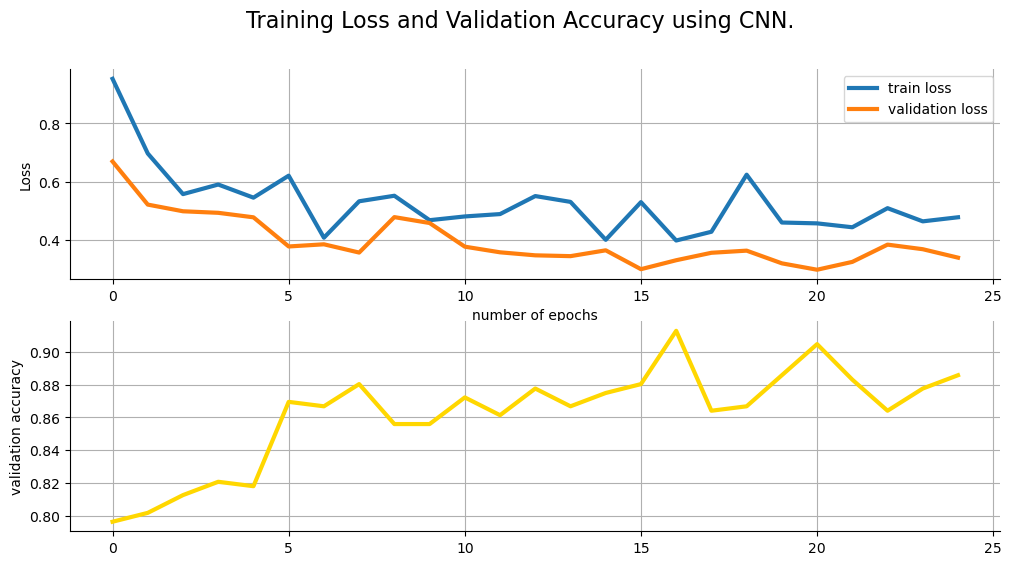

In [494]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using CNN.", fontsize=16)

sns.despine()

In [498]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model_CNN.eval()
        # Reshape test images into a vector
#         test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model_CNN(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 87.73% ± 2.39%


In [499]:
from torchsummary import summary
summary(model_CNN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 28, 28]             182
         MaxPool2d-2            [-1, 7, 14, 14]               0
         Dropout2d-3            [-1, 7, 14, 14]               0
            Conv2d-4           [-1, 14, 14, 14]           2,464
         MaxPool2d-5             [-1, 14, 7, 7]               0
         Dropout2d-6             [-1, 14, 7, 7]               0
            Linear-7                   [-1, 10]           6,870
Total params: 9,516
Trainable params: 9,516
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.04
Estimated Total Size (MB): 0.13
----------------------------------------------------------------
